## GANs to Augment and de-bias datasets

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

np.random.seed(123)

### Generating Synthetic Data

In [4]:
# Randomly sample 512-dimensional latent vectors.
# 6000 samples of 512 dim  
z_t0g0 = np.random.normal(0.1, 1, size=(6000, 512))   # contains neither t or g
z_t0g1 = np.random.normal(0.2, 1, size=(1000, 512))   # contains g, but not t

z_t1g0 = np.random.normal(-0.1, 1, size=(1000, 512))  # contains t, but not g
z_t1g1 = np.random.normal(-0.2, 1, size=(2000, 512))  # contains both t and g

# Stack everything so that all properties can be indexed from the array.
z = np.vstack((z_t0g0, z_t0g1, z_t1g0, z_t1g1))

# for target label
# Label the examples with whether they contain t.
t = np.zeros(10000) 
t[:7000] = 0 # doesnt have target label
t[7000:] = 1

# for Protected attribute
# Label the examples with whether they contain g.
g = np.zeros(10000)
g[:6000] = 0
g[6000:7000] = 1
g[7000:8000] = 0
g[8000:] = 1

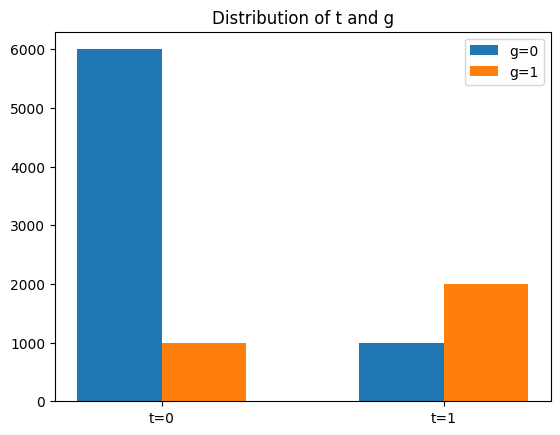

In [9]:
plt.title('Distribution of t and g')
plt.bar(np.arange(2), [np.logical_and(t==0, g==0).sum(), np.logical_and(t==1, g==0).sum()], width=0.3, label='g=0')
plt.bar(np.arange(2)+0.3, [np.logical_and(t==0, g==1).sum(), np.logical_and(t==1, g==1).sum()], width=0.3, label='g=1')
plt.xticks((0.15, 1.15), ('t=0', 't=1'))
plt.legend(loc='best')
plt.show()

Creating Train/Val/Test dataset

In [11]:
# Index of the data
train_indices = np.random.choice(10000, size=4000, replace=False)
val_indices = np.random.choice(list(set(np.arange(10000))-set(train_indices)), size=1000, replace=False)
test_indices = np.array(list(set(np.arange(10000)) - set(train_indices) - set(val_indices)))

# getting the real value
z_train = z[train_indices]
t_train = t[train_indices]
g_train = g[train_indices]

z_val = z[val_indices]
t_val = t[val_indices]
g_val = g[val_indices]

z_test = z[test_indices]
t_test = t[test_indices]
g_test = g[test_indices]

In [12]:
# Fitting a target attribute classifier in the latent space using a linear SVM.
h_t = svm.LinearSVC(max_iter=50000)
h_t.fit(z_train, t_train)

# Normalize so that w_t has norm 1.
w_t_norm = np.linalg.norm(h_t.coef_)
h_t.coef_ = h_t.coef_ / (w_t_norm)  # w_t
h_t.intercept_ = h_t.intercept_ / w_t_norm  # b_t

/home/jerlshin/env_ai/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [14]:
# Fit a protected attribute classifier in the latent space using a linear SVM.
h_g = svm.LinearSVC(max_iter=50000)
h_g.fit(z_train, g_train)

# Normalize so that w_g has norm 1.
w_g_norm = np.linalg.norm(h_g.coef_)
h_g.coef_ = h_g.coef_ / (w_g_norm)
h_g.intercept_ = h_g.intercept_ / w_g_norm

/home/jerlshin/env_ai/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [15]:
# Run inference with h(z) = w^T z + b.
t_val_prediction = np.sum(h_t.coef_ * z_val, axis=1) + h_t.intercept_
g_val_prediction = np.sum(h_g.coef_ * z_val, axis=1) + h_g.intercept_

# Calculate prediction accuracy
t_val_correct = np.logical_and(t_val == 1, t_val_prediction >= 0).sum() + np.logical_and(t_val == 0, t_val_prediction < 0).sum()
g_val_correct = np.logical_and(g_val == 1, g_val_prediction >= 0).sum() + np.logical_and(g_val == 0, g_val_prediction < 0).sum()
print('Accuracy of t classification: {}%'.format(t_val_correct / 1000 * 100))
print('Accuracy of g classification: {}%'.format(g_val_correct / 1000 * 100))

Accuracy of t classification: 98.4%
Accuracy of g classification: 80.0%
